# Imports

In [2]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import random
import networkx as nx
import scipy
import scipy.sparse as spa

from ItemRank import ItemRank

from BiRank import birank
from BiRank import gen_W

from datetime import datetime 
from sklearn.utils import shuffle
from datetime import datetime 
from networkx.algorithms import bipartite
from networkx.algorithms.bipartite import biadjacency_matrix
from numpy import linalg as LA
from scipy import sparse
from sklearn import preprocessing

In [3]:
# import data
df_artists = pd.read_excel('artists.xlsx')
df_listening_counts = pd.read_excel('user_artists.xlsx')

   1892 users, 17632 artists
               
   92834 user-listened artist relations, i.e. tuples (user, artist, listeningCount)
            

In [4]:
print(df_artists)
print(df_listening_counts)

       artistID               name
0             1       MALICE MIZER
1             2    Diary of Dreams
2             3  Carpathian Forest
3             4       Moi dix Mois
4             5        Bella Morte
...         ...                ...
17627     18741    Diamanda GalĂˇs
17628     18742             Aya RL
17629     18743        Coptic Rain
17630     18744       Oz Alchemist
17631     18745   Grzegorz Tomczak

[17632 rows x 2 columns]
       userID  artistID  weight
0           2        51   13883
1           2        52   11690
2           2        53   11351
3           2        54   10300
4           2        55    8983
...       ...       ...     ...
92829    2100     18726     337
92830    2100     18727     297
92831    2100     18728     281
92832    2100     18729     280
92833    2100     18730     263

[92834 rows x 3 columns]


In [5]:
# calculate artist mentions
df_A_M = df_listening_counts.groupby(['artistID']).agg(UserCount=pd.NamedAgg(column="userID", aggfunc="count"))
df_A_M = df_A_M.reset_index()
df_A_M.shape

(17632, 2)

Maximum number of mentiones for artists: 611
Average number of mentiones per artist: 5.265086206896552


Text(0.5, 0, 'Number of Fans')

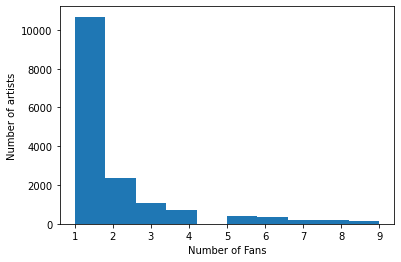

In [6]:
# som stats
print("Maximum number of mentiones for artists: {}".format(max(df_A_M['UserCount'])))
print("Average number of mentiones per artist: {}".format(np.mean(df_A_M['UserCount'])))
# hitogram fo mentions with < 10
plt.hist(df_A_M['UserCount'].loc[df_A_M['UserCount'] < 10])
plt.ylabel('Number of artists')
plt.xlabel('Number of Fans')


In [7]:
# choose artis with more than 5 mentions 
# select 5 
artists = df_A_M['artistID'].loc[df_A_M['UserCount'] >= 5]
print("Number of artists: {}".format(len(artists)))

Number of artists: 2828


In [8]:
 # ommit other artists
 df_NEW = df_listening_counts.loc[df_listening_counts['artistID'].isin(artists)]
 df_NEW.shape

(71426, 3)

# Network construction

In [9]:
# Summary
print("Number of Users: {}".format(len(df_NEW['userID'].unique())))
print("Number of artists: {}".format(len(df_NEW['artistID'].unique())))
print("Number of listening relations: {}".format(len(df_NEW['artistID'])))
print('Density: ' + str(round(len(df_NEW) / (len(df_NEW['artistID'].unique()) * len(df_NEW['userID'].unique())),4)))

Number of Users: 1881
Number of artists: 2828
Number of listening relations: 71426
Density: 0.0134


In [ ]:
 # create weight bins for listening counts
 df_NEW['weightQuantile'] = pd.qcut(df_NEW['weight'], q=10)
 bin_labels_10 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 df_NEW['weightLabel'] = pd.qcut( df_NEW['weight'],
                              q=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                              labels=bin_labels_10)
 print('Counts for weight labes')
 print(df_NEW[['weightQuantile','weightLabel']].value_counts())
 df_NEW.reset_index(drop=True, inplace=True)
 df_NEW.shape 

In [11]:
# shuffle dataset
df_NEW_shuffled = shuffle(df_NEW, random_state=1)
df_NEW_shuffled

,userID,artistID,weight,weightQuantile,weightLabel
2857,78,101,114,"(95.0, 147.0]",3
70777,2078,1104,1381,"(850.0, 1535.0]",9
8493,234,1640,595,"(560.0, 850.0]",8
50553,1471,538,79,"(45.0, 95.0]",2
53988,1572,498,579,"(560.0, 850.0]",8
...,...,...,...,...,...
49100,1430,7723,108,"(95.0, 147.0]",3
20609,578,466,292,"(287.0, 396.0]",6
21440,605,707,346,"(287.0, 396.0]",6
50057,1457,461,7916,"(1535.0, 352698.0]",10


In [12]:
# select 40k training reviews 
df_TRAIN = df_NEW_shuffled[:40000]
df_TRAIN.insert(5, 'Label', 0)
print("Number of Users: {}".format(len(df_TRAIN['userID'].unique())))
print("Number of artists: {}".format(len(df_TRAIN['artistID'].unique())))
print("Number of listening relations: {}".format(len(df_TRAIN['artistID'])))

Number of Users: 1877
Number of artists: 2815
Number of listening relations: 40000


In [13]:
# and the rest are test reviews (connection that arised)
df_TEST = df_NEW_shuffled[40000:]
df_TEST.insert(5, 'Label', 1)
print("Number of Users: {}".format(len(df_TEST['userID'].unique())))
print("Number of artists: {}".format(len(df_TEST['artistID'].unique())))
print("Number of listening relations: {}".format(len(df_TEST['artistID'])))

Number of Users: 1874
Number of artists: 2787
Number of listening relations: 31426


# Itemrank

In [ ]:
# numpy array conversion for itemrank algorithm
np_data = np.array(df_TRAIN[['userID', 'artistID', 'weightLabel']])
print(np_data.shape)

np_data_test = np.array(df_TEST[['userID', 'artistID', 'weightLabel']])
print(np_data_test.shape)

(40000, 3)


In [ ]:
start_time = time.time()

# generate object
item_rank = ItemRank(np_data)

item_rank.generate_graph()
item_rank.generate_coef_from_graph()
print(item_rank.correlation_matrix.shape)

Exec_time_CM = round((time.time() - start_time)/60)
print("Initial settings Execution Time: {}".format(Exec_time_CM))

(2815, 2815)
Initial settings Execution Time: 1


In [ ]:
# calculate itemranks
start_time = time.time()
IRs = []
DOAs = []
UserCounter = 0
for user_name in item_rank.user_names:
    UserCounter +=  1
    d = item_rank.generate_d(user_name=user_name)
    IR = np.ones(len(item_rank.movie_names))
    old_IR = IR
    converged = False
    counter = 0
    while not converged:
      counter += 1
      old_IR = IR
      IR = item_rank.item_rank(0.85 , IR , d)
      converged = (old_IR - IR < 0.0001).all()
    print( "Converged after "+str(counter)+" counts.")
    print("User counter: {}".format(UserCounter))
    Exec_time_R = round((time.time() - start_time)/60)
    print("Execution time: {}".format(Exec_time_R))
    IRs.append(IR)

    if user_name in np_data_test[:,0]:      
      doa = item_rank.calculate_DOA(np_data_test, user_name , IR)
      DOAs.append(doa)
      print("DOA for user %s is : %s" %(user_name, doa))

np.array(IRs).shape

Streaming output truncated to the last 5000 lines.
User counter: 626
Execution time: 28
DOA for user 678 is : 0.8083594458998989
Converged after 67 counts.
User counter: 627
Execution time: 28
DOA for user 679 is : 0.799179894739067
Converged after 66 counts.
User counter: 628
Execution time: 28
DOA for user 680 is : 0.7897706834532374
Converged after 67 counts.
User counter: 629
Execution time: 28
DOA for user 681 is : 0.7627256820170206
Converged after 67 counts.
User counter: 630
Execution time: 28
DOA for user 682 is : 0.9456409874889955
Converged after 67 counts.
User counter: 631
Execution time: 28
DOA for user 683 is : 0.9039725209080047
Converged after 67 counts.
User counter: 632
Execution time: 28
DOA for user 684 is : 0.9884591017277101
Converged after 67 counts.
User counter: 633
Execution time: 28
DOA for user 685 is : 0.8356567838209307
Converged after 67 counts.
User counter: 634
Execution time: 28
DOA for user 686 is : 0.8963620901445715
Converged after 67 counts.
User 

(1877, 2815)

In [ ]:
# average performance DOA (percentage of movie paires ranked in correct order)
sum(DOAs)/len(DOAs)

0.8523086758151704

In [ ]:
# put into dataframe
df_IRs = pd.DataFrame(IRs)
df_IRs.columns = item_rank.movie_names
df_IRs['userID'] = item_rank.user_names
cols = list(df_IRs.columns)
cols = [cols[-1]] + cols[:-1]
df_IRs = df_IRs[cols]
df_IRs

,userID,2,6,7,8,9,10,11,12,13,15,16,17,18,19,8215,25,27,28,30,32,34,36,8229,8230,39,40,41,38,37,45,47,49,51,52,53,54,55,56,8244,...,7704,7706,7723,7724,7742,7743,7756,7759,7777,7781,7810,7831,7832,7834,7835,7838,7846,7864,7868,7874,7885,7927,7935,8002,8027,8042,8043,8047,8054,8067,8071,8081,8111,8121,8123,8126,8136,8155,8160,8161
0,2,0.033085,0.013542,0.383472,0.021793,0.068519,0.021815,0.012098,0.019084,0.030652,0.036505,0.018849,0.016450,0.036860,0.032035,0.019293,0.047468,0.021166,0.004798,0.119277,0.069224,0.029490,0.042953,0.014149,0.002211,0.021412,0.039145,0.025538,0.003505,0.007946,0.076560,0.007394,0.034486,0.606621,0.126711,2.015687,1.702094,0.869839,0.415155,0.001223,...,0.006947,0.012204,0.019248,0.006681,0.008999,0.025318,0.006380,0.002580,0.024686,0.023597,0.017253,0.007141,0.019608,0.016271,0.019768,0.011455,0.016601,0.004678,0.029290,0.021484,0.049703,0.004383,0.013066,0.012202,0.027925,0.022374,0.024129,0.030651,0.008296,0.013816,0.019202,0.012369,0.028232,0.014197,0.014793,0.024470,0.013549,0.018919,0.013322,0.013814
1,3,0.000478,0.000197,0.005349,0.000324,0.000784,0.000338,0.000142,0.000376,0.000517,0.000576,0.000203,0.000238,0.000488,0.000474,0.007143,0.000777,0.000326,0.000075,0.000984,0.000696,0.000378,0.000637,0.000145,0.000046,0.000208,0.000583,0.000340,0.000045,0.000158,0.001191,0.000132,0.000316,0.004623,0.001830,0.016193,0.001028,0.010483,0.006620,0.000019,...,0.000097,0.000165,0.000327,0.000118,0.000125,0.000497,0.000094,0.000044,0.000367,0.000351,0.000218,0.000113,0.000333,0.000256,0.000289,0.000177,0.000238,0.000057,0.000343,0.000086,0.000425,0.000061,0.000170,0.000136,0.000744,0.000331,0.000390,0.000434,0.000142,0.000169,0.000241,0.000159,0.000359,0.000297,0.000230,0.000556,0.000177,0.000272,0.000110,0.000210
2,4,0.026130,0.010801,0.213390,0.016227,0.035158,0.017832,0.008175,0.013955,0.026476,0.033541,0.008126,0.008111,0.025283,0.024294,0.008369,0.035074,0.007838,0.004577,0.050143,0.036141,0.015975,0.023856,0.006433,0.001198,0.011611,0.021147,0.016980,0.002098,0.004230,0.046962,0.007328,0.013191,0.265843,0.076214,0.164044,0.034005,0.414826,0.187192,0.000721,...,0.003582,0.005407,0.010236,0.003529,0.003733,0.013283,0.003656,0.001087,0.014054,0.010376,0.006646,0.003847,0.010340,0.008693,0.012922,0.006454,0.010192,0.002132,0.013227,0.003185,0.014029,0.002511,0.008695,0.005046,0.016486,0.018974,0.015889,0.017846,0.005833,0.009053,0.007974,0.005567,0.015631,0.005754,0.007914,0.013318,0.004476,0.008941,0.003221,0.005454
3,5,0.013615,0.007683,0.217149,0.013163,0.029814,0.010606,0.004169,0.012287,0.014788,0.025299,0.007847,0.020303,0.020971,0.026765,0.007438,0.029526,0.008300,0.002837,0.031772,0.022886,0.011704,0.019636,0.005526,0.001359,0.021723,0.021201,0.010628,0.001279,0.003534,0.061303,0.003649,0.009378,0.166691,0.043940,0.176025,0.029672,0.365044,0.219705,0.000735,...,0.003596,0.005298,0.013731,0.004398,0.005535,0.017312,0.003606,0.001356,0.014438,0.010738,0.006969,0.004172,0.012618,0.010487,0.015140,0.006255,0.008409,0.001993,0.011888,0.002925,0.013486,0.002303,0.007365,0.004633,0.017887,0.018509,0.017145,0.015832,0.008131,0.006142,0.008123,0.005325,0.014046,0.007145,0.008961,0.014459,0.004744,0.011004,0.003617,0.005927
4,6,0.001184,0.000652,0.021042,0.001454,0.002250,0.000846,0.000308,0.000988,0.001122,0.001913,0.000606,0.000542,0.001548,0.001049,0.000512,0.002901,0.000615,0.000250,0.002685,0.001805,0.000941,0.001507,0.000786,0.000990,0.000635,0.001676,0.000810,0.000102,0.000261,0.004918,0.000335,0.000687,0.017828,0.003882,0.014466,0.003445,0.087924,0.018462,0.000076,...,0.000484,0.001130,0.001274,0.000377,0.000341,0.001479,0.000429,0.000140,0.001664,0.001689,0.001662,0.001180,0.001355,0.001182,0.001797,0.000792,0.001368,0.000406,0.002495,0.000416,0.001055,0.000697,0.000573,0.000986,0.001397,0.001158,0.001028,0.001891,0.000403,0.002027,0.004634,0.006077,0.001153,0.000595,0.000729,0.001187,0.000390,0.001195,0.000482,0.001730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

# BiRank

In [14]:
# add artists names
df_TRAIN = df_TRAIN.join(df_artists.set_index(['artistID']), on= ['artistID'], how='inner')
df_TEST = df_TEST.join(df_artists.set_index(['artistID']), on= ['artistID'], how='inner')

In [15]:
# Calculate Inputs
W, users, items =  gen_W(df_TRAIN['userID'], df_TRAIN['name'], df_TRAIN['weightLabel'])

Shape of W: (1877, 2815)


In [16]:
# calculate BiRank
start_time = time.time()

a = 0.8
b = 0.8
BRs = []
DOAs = []
UserCounter = 0
for user_name in users:
    UserCounter +=  1
    print("User counter: {}".format(UserCounter))
    # set normalized inital vector
    v0 =  (W.toarray()[UserCounter-1,:])/(W.toarray()[UserCounter-1,:].sum())
    # calculate ranks of items for a user
    u, v = birank(W, v0=v0, alpha=a, beta=b, max_iter=200, tol=0.0001, verbose=False)
    BR = v

    Exec_time_R = round((time.time() - start_time)/60)
    print("Execution time: {}".format(Exec_time_R))
    # append
    BRs.append(BR)

    
np.array(BRs).shape

User counter: 1
Execution time: 0
User counter: 2
Execution time: 0
User counter: 3
Execution time: 0
User counter: 4
Execution time: 0
User counter: 5
Execution time: 0
User counter: 6
Execution time: 0
User counter: 7
Execution time: 0
User counter: 8
Execution time: 0
User counter: 9
Execution time: 0
User counter: 10
Execution time: 0
User counter: 11
Execution time: 0
User counter: 12
Execution time: 0
User counter: 13
Execution time: 0
User counter: 14
Execution time: 0
User counter: 15
Execution time: 0
User counter: 16
Execution time: 0
User counter: 17
Execution time: 0
User counter: 18
Execution time: 0
User counter: 19
Execution time: 0
User counter: 20
Execution time: 0
User counter: 21
Execution time: 0
User counter: 22
Execution time: 0
User counter: 23
Execution time: 0
User counter: 24
Execution time: 0
User counter: 25
Execution time: 0
User counter: 26
Execution time: 0
User counter: 27
Execution time: 0
User counter: 28
Execution time: 0
User counter: 29
Execution ti

(1877, 2815)

In [17]:
# put into dataframe
df_BRs = pd.DataFrame(BRs)
df_BRs.columns = items
df_BRs['userID'] = users
cols = list(df_BRs.columns)
cols = [cols[-1]] + cols[:-1]
df_BRs = df_BRs[cols]
df_BRs

,userID,Pleq,Rammstein,GZA/Genius,Maroon 5,Paramore,Misfits,She & Him,ĺ€–ç”°äľ†ćśŞ,Gwen Stefani,Cine,Rihanna,Nicki Minaj,The Cure,David Guetta,Kylie Minogue,Soundgarden,Broken Social Scene,Hey Monday,Ellie Goulding,Black Eyed Peas,Billy Talent,Within Temptation,Beirut,Breaking Benjamin,Alesha Dixon,MF DOOM,Hadouken!,Taylor Swift,Social Distortion,U2,The Drums,Franz Ferdinand,Queen,Jessie J,AFI,Timbaland,Michael Jackson,Queens of the Stone Age,Katharine McPhee,...,Dawn of Ashes,Low,I Am Kloot,Daniela Mercury,Neon Indian,Streetlight Manifesto,J. Holiday,Rouge,Edyta Bartosiewicz,Apulanta,Little Brother,Planet Funk,Kellie Pickler,Juan Luis Guerra,Luis Fonsi,Novos Baianos,Joe Bonamassa,Craig Armstrong,Blaze,CunninLynguists,Azam Ali,Pizzicato Five,Dirty Projectors,ISAN,Goose,Finntroll,Big D and the Kids Table,www.djrobsonmichel.com,The Classic Crime,A Wilhelm Scream,Etta James,Bushido,8mm,The Microphones,JoĂŁo Gilberto,Falco,Funker Vogt,The Thermals,Randy Newman,Lake of Tears
0,78,0.008525,0.000835,0.000206,0.000575,0.001061,0.000546,0.000395,0.000326,0.000493,0.000203,0.001031,0.000346,0.001110,0.000493,0.000817,0.000325,0.000370,0.000298,0.000379,0.000737,0.000476,0.000526,0.000518,0.000513,0.000123,0.000446,0.000515,0.000774,0.000194,0.000820,0.000225,0.000712,0.000701,0.000295,0.000461,0.000403,0.000807,0.000717,0.000268,...,0.000098,0.000072,0.000057,0.000099,0.000094,0.000087,0.000131,0.000092,0.000072,0.000037,0.000105,0.000187,0.000075,0.000100,0.000043,0.000113,0.000163,0.000106,0.000083,0.000116,0.000096,0.000085,0.000060,0.000583,0.000154,0.000078,0.000085,0.000032,0.000074,0.000086,0.000091,0.000094,0.000057,0.000095,0.000067,0.000044,0.000127,0.000074,0.000056,0.000205
1,255,0.008016,0.000793,0.000237,0.000575,0.001097,0.000500,0.000404,0.000334,0.000559,0.000213,0.001117,0.000372,0.001109,0.000532,0.000900,0.000352,0.000395,0.000312,0.000447,0.000799,0.000448,0.000536,0.000562,0.000486,0.000130,0.000460,0.000408,0.000808,0.000205,0.000885,0.000239,0.000776,0.000766,0.000312,0.000416,0.000440,0.000917,0.000719,0.000281,...,0.000091,0.000077,0.000081,0.000105,0.000141,0.000090,0.000146,0.000098,0.000098,0.000039,0.000171,0.000099,0.000076,0.000159,0.000046,0.000132,0.000127,0.000115,0.000076,0.000126,0.000088,0.000118,0.000065,0.005348,0.000202,0.000075,0.000087,0.000033,0.000076,0.000085,0.000096,0.000102,0.000100,0.000079,0.000111,0.000046,0.000112,0.000078,0.000055,0.000084
2,1740,0.011116,0.000902,0.000246,0.000765,0.001318,0.000589,0.000553,0.000447,0.000708,0.000256,0.001370,0.000462,0.011160,0.000624,0.001175,0.000439,0.000634,0.000406,0.000508,0.000981,0.000522,0.000626,0.000829,0.000584,0.000162,0.000445,0.000532,0.000972,0.000283,0.001074,0.000483,0.001100,0.000925,0.000381,0.000456,0.000590,0.001098,0.000952,0.000322,...,0.000097,0.000092,0.000054,0.000129,0.000131,0.000105,0.000110,0.000112,0.000159,0.000072,0.000146,0.000109,0.000084,0.000107,0.000052,0.000139,0.000130,0.000142,0.000084,0.000211,0.000094,0.000092,0.000175,0.000239,0.000347,0.000081,0.000106,0.000036,0.000160,0.000095,0.000109,0.000107,0.000069,0.000163,0.000084,0.000060,0.000107,0.000082,0.000058,0.000086
3,1891,0.014029,0.000785,0.000152,0.000563,0.001035,0.000430,0.000326,0.000279,0.000469,0.000192,0.000990,0.000330,0.000855,0.000470,0.000783,0.000311,0.000322,0.000281,0.000350,0.000708,0.000362,0.000468,0.000460,0.000488,0.000119,0.000269,0.000697,0.000738,0.000155,0.000698,0.000196,0.000727,0.000616,0.000285,0.000428,0.000384,0.000721,0.000735,0.000258,...,0.000075,0.000067,0.000043,0.000094,0.000087,0.000079,0.000131,0.000089,0.000068,0.000036,0.000088,0.000080,0.000070,0.000084,0.000042,0.000096,0.000116,0.000120,0.000067,0.000125,0.000078,0.000072,0.000054,0.000516,0.000103,0.000065,0.000078,0.000031,0.000070,0.000076,0.000085,0.000078,0.000110,0.000069,0.000064,0.000041,0.000089,0.000069,0.000045,0.000070
4,2078,0.000176,0.014037,0.000210,0.000786,0.001424,0.000591,0.000516,0.000352,0.000697,0.000336,0.001371,0.000451,0.001167,0.0006

# Feature engneering

In [18]:
# save pairs with label 1 - from network itemrank test pairs
df_Label1 = df_TEST[['userID','artistID', 'name', 'Label']]
df_Label1.shape

(31426, 4)

In [ ]:
# select label 0 connections 
# generate 40k random for Dataset_2 and 35k random for Dataset_1
random.seed(30)
df_Label0 = pd.DataFrame(index=range(50000), columns=['userID', 'artistID'])
for i in range(50000):    
    df_Label0['userID'][i] = random.choice(list(df_Label1['userID'].unique()))
    df_Label0['artistID'][i]= random.choice(list(df_Label1['artistID'].unique()))

In [ ]:
# drop duplicates
df_Label0 = df_Label0.drop_duplicates()

# filter pairs that already exists
# create dataframe with existing pairs
df_exist = df_NEW[['userID', 'artistID']]
df_exist.insert(2, 'Label2', 2)
# left join to labeled0
df_Label0_adj = df_Label0.join(df_exist.set_index(['userID', 'artistID']), on= ['userID', 'artistID'], how='left')
# now remove interseted paires
df_Label0_final = df_Label0_adj[['userID', 'artistID']].loc[~(df_Label0_adj['Label2']==2)]

# join artist name
df_Label0_final = df_Label0_final.join(df_artists.set_index('artistID'), on= 'artistID', how='inner')
df_Label0_final.insert(3, 'Label', 0)
df_Label0_final = df_Label0_final[['userID','artistID','name','Label']] 

In [ ]:
# join to labeled1
df_Labeled_Final = pd.concat([df_Label1, df_Label0_final])
df_Labeled_Final

,userID,artistID,name,Label
8721,241,1412,Led Zeppelin,1
45735,1331,1412,Led Zeppelin,1
70746,2077,1412,Led Zeppelin,1
26236,738,1412,Led Zeppelin,1
23963,678,1412,Led Zeppelin,1
...,...,...,...,...
38726,717,2436,Keith Urban,0
44186,2028,2436,Keith Urban,0
46091,1265,2436,Keith Urban,0
47124,981,2436,Keith Urban,0


In [ ]:
df_Labeled = df_Labeled_Final.copy()

In [ ]:
print(len(df_Labeled.loc[df_Labeled['Label'] == 1]))
print(len(df_Labeled.loc[df_Labeled['Label'] == 0]))

31426
49077


In [ ]:
# add ItemRank to labeled pairs
ARTS = df_IRs.columns.tolist()
USRS = df_IRs['userID'].tolist()
hodnoty = []
ir = 0
for i in range(len(df_Labeled)):
    if (df_Labeled['artistID'].values[i] in ARTS) and (df_Labeled['userID'].values[i] in USRS):
        ir = df_IRs[df_Labeled['artistID'].values[i]].loc[df_IRs['userID'] == df_Labeled['userID'].values[i]].values[0]
        hodnoty.append(ir) 
    else:
        hodnoty.append('NX')

# removes pairs we didn't get ir
df_Labeled['IR'] = hodnoty
df_Labeled = df_Labeled.loc[~(df_Labeled['IR'] == 'NX')]

In [ ]:
# add BiRank to labeled pairs
ITMS = df_BRs.columns.tolist()
USRS = df_BRs['userID'].tolist()
hodnoty = []
br = 0
for i in range(len(df_Labeled)):
    if (df_Labeled['name'].values[i] in ITMS) and (df_Labeled['userID'].values[i] in USRS):
        br = df_BRs[df_Labeled['name'].values[i]].loc[df_BRs['userID'] == df_Labeled['userID'].values[i]].values[0]
        hodnoty.append(br) 
    else:
        hodnoty.append('NX')

# removes pairs we didn't get br
df_Labeled['BR'] = hodnoty
df_Labeled = df_Labeled.loc[~(df_Labeled['BR'] == 'NX')]

In [ ]:
# Final labeled dataset ready for binary classification
df = df_Labeled
df = shuffle(df, random_state=0)
df

,userID,artistID,name,Label,IR,BR
44022,781,5475,Blue Foundation,0,0.00875716,0.000198
44856,1772,6543,Millionaires,0,0.00973138,0.000137
20707,1323,507,Saosin,0,0.0858171,0.000807
48957,1427,11206,The Black Dog,1,0.000920861,0.000067
19571,18,10672,Voivod,0,0.00928087,0.000204
...,...,...,...,...,...,...
45789,1332,3575,Blake Lewis,1,0.0574195,0.000618
4308,718,1507,Omarion,0,0.0053326,0.000092
10310,106,2896,Albert Collins,0,0.00683869,0.000156
37510,1582,396,L'Arc~en~Ciel,0,0.00781698,0.000198


In [ ]:
print(len(df.loc[df['Label'] == 1]))
print(len(df.loc[df['Label'] == 0]))

31353
48707
